<div id="container" style="position:relative;">
<div style="float:left"><h1>Data Preparation and Exploration: Issued Building Permits </h1></div>
<div style="position:relative; float:right">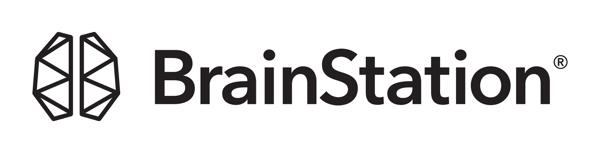
</div>
</div>


**Author:** Tatyana Mozgacheva

## Table of Contents
[Introduction](#Introduction) 

[1. Loading data & checking high-level details](#1.-Loading-data-&-checking-high-level-details) <br>
- [Data Dictionary](#Data-Dictionary) <br>

[2. Data preparation and cleaning](#Data-preparation-and-cleaning) <br>

[3. Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
- [Univariate Visualizations](#Univariate-Visualizations) <br>
- [Multivariate Visualizations](#Multivariate-Visualizations) <br>
- [Time Series](#Time-Series) <br>
- [Mapping issued permits on the Vancouver map](#Mapping-issued-permits-on-the-Vancouver-map) <br>

[4. Conclusion](#Conclusion)

In [359]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import plotly.express as px


# Introduction

## Dataset
Throughout this notebook I will use the `issued-building-permits.csv` dataset. 

Building permits are required for new buildings, additions or alterations to existing buildings, and for demolitions or salvage and abatement work.

You can download the dataset from [here](https://opendata.vancouver.ca/explore/dataset/issued-building-permits/export/)

The GitHub project is [here](https://github.com/tmozgach/brainstation_capstone_building_permits) 

## Question of interest

> Does the time it takes to obtain a permit relate to factors like property values, type of work, property use, and location, etc?

## 1. Loading data & checking high-level details

In [360]:
df = pd.read_csv('issued-building-permits.csv', delimiter=";")
df = df[df['IssueYear'] != 2024]
# There may be some loss of quality from data entry errors and omissions, 
# in particular where the original application date was prior to May 2016 (when permit software changed).
df = df[df['IssueYear'] != 2013]
df = df[df['IssueYear'] != 2014]
df = df[df['IssueYear'] != 2015]
df = df[df['IssueYear'] != 2016]
df.head()


,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,Address,ProjectDescription,PermitCategory,Applicant,ApplicantAddress,PropertyUse,SpecificUseCategory,BuildingContractor,BuildingContractorAddress,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
0,DB-2023-00041,2023-01-05,2023-04-28,113,198847.5,New Building,"7475 DUMFRIES STREET, Vancouver, BC",Low Density Housing - New Building - To constr...,New Build - Standalone Laneway,Shalindro Dosanjh,"1185 49 th Ave West\r\nVancouver,, BC V6M 2P9",Dwelling Uses,Laneway House,Amcata Homes Developments Ltd,"1185 W 49TH AV \r\nVancouver, BC V6M 2P9",2023,Victoria-Fraserview,"{""coordinates"": [-123.0755831, 49.2165995], ""t...",2023-04,"49.2165995, -123.0755831"
1,BP-2023-00049,2023-01-06,2023-03-29,82,0.0,Salvage and Abatement,"1137 E 29TH AVENUE, Vancouver, BC V5V 2S7",Low Density Housing - Salvage and Abatement - ...,NaN,John Keen DBA: Farpoint Architectural Inc.,"1662 West 75th Ave.\r\nVancouver, BC V6P 6G2",Dwelling Uses,Single Detached House,Vancouver Excavating and Contracting Ltd,"25 Howard Ave \r\nBurnaby, BC V5B 3P3",2023,Kensington-Cedar Cottage,"{""coordinates"": [-123.081827, 49.244843], ""typ...",2023-03,"49.244843, -123.081827"
2,DB-2023-00050,2023-01-06,2023-09-12,249,1068777.5,New Building,"85 W 48TH AVENUE, Vancouver, BC V5Y 2Y5",Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Embark Homes DBA: Embark Homes LTD,"501-4289 Hastings Street\r\nBurnaby, BC V5C0K9",Dwelling Uses,Single Detached House w/Sec Suite,Embark Homes LTD,NaN,2023,Oakridge,"{""coordinates"": [-123.1079161, 49.2270346], ""t...",2023-09,"49.2270346, -123.1079161"
3,DB-2023-00064,2023-01-06,2023-10-04,271,155030.0,New Building,"95 E 59TH AVENUE #3, Vancouver, BC",Low Density Housing - New Building - To constr...,New Build - Standalone Laneway,Wayne Ng DBA: Skymark Engineering Ltd,"3383 Queens Ave\r\nVancouver, BC V5R 4T9",Dwelling Uses,Laneway House,Semlin Construction Ltd,"949 Esmond Ave \r\nBurnaby, BC V5C 6A6",2023,Sunset,"{""coordinates"": [-123.1041746, 49.2170343], ""t...",2023-10,"49.2170343, -123.1041746"
4,DB-2023-00065,2023-01-06,2023-03-31,84,692250.0,New Building,NaN,Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Jordan Talhan DBA: 0686632 BC LTD,"12945 56A Avenue \r\nSurrey, BC V3X2Z1",Dwelling Uses,Duplex w/Secondary Suite,Rungur Sherhomes Group Ltd,NaN,2023,NaN,NaN,2023-03,NaN


In [361]:
df[df["Applicant"].str.contains("Bosa")]

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,Address,ProjectDescription,PermitCategory,Applicant,ApplicantAddress,PropertyUse,SpecificUseCategory,BuildingContractor,BuildingContractorAddress,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
12153,BP-2022-01648,2022-03-31,2022-10-06,189,98790.0,Addition / Alteration,"266 E 21ST AVENUE #3, Vancouver, BC V5V 1R1",Low Density Housing - Addition / Alteration - ...,NaN,Dan Cupa DBA: Bosa Properties Inc.,"1201-838 West Hastings Street\r\nVancouver, BC...",Dwelling Uses,Dwelling Unit,NaN,NaN,2022,Riley Park,"{""coordinates"": [-123.0995056, 49.2517963], ""t...",2022-10,"49.2517963, -123.0995056"
14569,BP-2022-03905,2022-08-09,2022-08-23,14,1098000.0,Addition / Alteration,"888 W BROADWAY, Vancouver, BC V5Z 1J8",Field Review - Addition / Alteration - Interio...,Renovation - Commercial/ Mixed Use - Lower Com...,Nina Santiago DBA: Bosa Properties Inc.,838 West Hastings Street\r\nSuite 1100\r\nVanc...,Service Uses,Hotel,Axiom Builders Inc,"838 W HASTINGS ST \r\nUnit 1100\r\nVancouver,...",2022,Fairview,"{""coordinates"": [-123.1227206, 49.2630287], ""t...",2022-08,"49.2630287, -123.1227206"
16571,BP-2022-00293,2022-01-20,2022-04-01,71,1505000.0,Demolition / Deconstruction,"1500 W GEORGIA STREET, Vancouver, BC V6G 2Z6",Enquiry Centre - Demolition / Deconstruction -...,NaN,Bosa Properties Inc.,"838 W Hastings St.\r\n#1100\r\nVancouver, BC ...","Parking Uses,Retail Uses","Parking Area,Retail Store",Axiom Builders Inc,"838 W HASTINGS ST \r\nUnit 1100\r\nVancouver,...",2022,West End,"{""coordinates"": [-123.1307382, 49.2902096], ""t...",2022-04,"49.2902096, -123.1307382"
22472,BP-2018-00821,2018-02-16,2018-03-02,14,12000.0,Salvage and Abatement,"320 GRANVILLE STREET, Vancouver, BC V6C 1S9",Enquiry Centre - Salvage and Abatement - Inter...,NaN,Alistair Clark DBA: Bosa Development,"1300-2025 Willingdon Ave\r\nBurnaby, BC V5C 0J3",Parking Uses,Parking Garage,Bosa Development Corp,"1901 Rosser Av \r\nUnit 500\r\nBurnaby, BC V...",2018,Downtown,"{""coordinates"": [-123.1128415, 49.2855713], ""t...",2018-03,"49.2855713, -123.1128415"
22662,BP-2018-01506,2018-03-20,2018-05-09,50,1600000.0,Demolition / Deconstruction,"320 GRANVILLE STREET, Vancouver, BC V6C 1S9",Enquiry Centre - Demolition / Deconstruction -...,NaN,Alistair Clark DBA: Bosa Development,"1300-2025 Willingdon Ave\r\nBurnaby, BC V5C 0J3",Parking Uses,Parking Garage,Bosa Development Corp,"1901 Rosser Av \r\nUnit 500\r\nBurnaby, BC V...",2018,Downtown,"{""coordinates"": [-123.1128415, 49.2855713], ""t...",2018-05,"49.2855713, -123.1128415"
28324,BP-2022-00294,2022-01-20,2022-03-24,63,0.0,Salvage and Abatement,"1500 W GEORGIA STREET, Vancouver, BC V6G 2Z6",Enquiry Centre - Salvage and Abatement - Inter...,NaN,Bosa Properties Inc.,"838 W Hastings St.\r\n#1100\r\nVancouver, BC ...","Parking Uses,Retail Uses","Parking Area,Retail Store",NaN,NaN,2022,West End,"{""coordinates"": [-123.1307382, 49.2902096], ""t...",2022-03,"49.2902096, -123.1307382"


### Data Dictionary

| Field Name | Type | Description | Sample |
|------------|------|-------------|--------|
| PermitNumber | text | Unique permit number generated at application date; there may be multiple permits for one project site BU - Original Permit application was made in previous software BP - Building Permit DB - Combined Development & Building Permit | BP-2019-04164 |
| PermitNumberCreatedDate | date | The date at which a permit application, created by staff or an online process, receives a permit number | 2019-09-17 |
| IssueDate | date | Date when the specified permit was first issued | 2019-11-15 |
| PermitElapsedDays | integer | Measures the number of days from the creation and assignment of a permit number until the issuance of a permit.  Application processing represents a collaboration between the applicant/customer team and the City.  Timelines may be influenced by a number of factors, some of which include: the volume of instream applications to be processed, completeness of the application, site and project specific requirements impacting application requirements (number of reviews, conditions, design decisions, etc.), staff and customer response times. | 59 |
| ProjectValue | decimal | Estimated construction value at time of original permit issuance; base permit fees are calculated on this value. For commercial and mixed-use projects with multiple buildings on one site, the project value may be entered only on the site permit (and not the permits for each individual building where a $0 value will be shown) | 0 |
| TypeOfWork | text | Categories Include: Addition / Alteration, Demolition / Deconstruction, New Buildings, Outdoor Uses (No Buildings Proposed), Salvage and Abatement, Temporary Buildings / Structures | Salvage and Abatement |
| Address | text | Specific Property Address | 4094 W 30TH AVENUE, Vancouver, BC V6S 1X5 |
| ProjectDescription | text | Scope of work (note: data file prior to 2018 does not include this field) | Low Density Housing - Salvage and Abatement - SALVAGE AND ABATEMENT PERMIT Salvage and Abatement Permit only for Building permit: DB-2019-04161 and to be completed under the supervision of a registered professional.  This permit does not authorize demolition, deconstruction or construction work. QP:  MCA Environmental Consulting Inc. (Tarlochan (Terry) Sunar) Demolition permit: DB-2019-04162 |
| PermitCategory | text | A high level grouping providing a focus on higher volume, lower complexity project scopes. The categorization is derived from data in the TypeofWork, PropertyUse and ProjectDescription fields. This field was added in December 2021 and will be modified to take into account feedback from dataset users | - |
| Applicant | text | Applicant may be property owner or official agent for owner and is often the design professional or their firm | Scott Posno DBA: Scott Posno Design |
| ApplicantAddress | text | Contact information as provided on Permit Application | 1595 W 3rd Avenue Vancouver, BC  V6J 1J8 |
| PropertyUse | text | General use of property; where there is more than one, they are separated by a comma | Dwelling Uses |
| SpecificUseCategory | text | Category of property use; where there is more than one, they are separated by a comma | Single Detached House |
| BuildingContractor | text | Contractor information, if known, at time of permit issuance | Mercia Construction Ltd |
| BuildingContractorAddress | text | Contractor information, as provided by the applicant | - |
| IssueYear | text | Year which permit was first issued | 2019 |
| GeoLocalArea | text | The local area where the building with the Issued Building Permit is found, derived from the building's coordinates or address. The City of Vancouver has 22 local areas (also known as local planning areas). For more details, please see the Local Area Boundary data set. | Dunbar-Southlands |
| Geom | geo shape | These are mapping coordinates for the building corresponding to a Building Permit. Data from the Address attribute are processed by the BC Address Geocoder API. An unmatched address returns null coordinates and will not display on the Map. The permit will still be listed in the Table view. | {"coordinates":[-123.1965627,49.2450036],"type":"Point"} |
| YearMonth | text | No description available for this field. | 2019-11 |
| geo_point_2d | geo point | No description available for this field. | [49.2450036,-123.1965627] |



In [362]:
df.tail()

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,Address,ProjectDescription,PermitCategory,Applicant,ApplicantAddress,PropertyUse,SpecificUseCategory,BuildingContractor,BuildingContractorAddress,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
39552,BP-2023-02460,2023-07-12,2023-11-09,120,2200000.0,Addition / Alteration,"1090 W PENDER STREET, Vancouver, BC V6E 2N7",Certified Professional Program - Addition / Al...,NaN,"Robert Heikkila DBA: CFT Engineering Inc., a J...","#500 - 1901 Rosser Avenue\r\nBurnaby, BC V5C 6R6",Office Uses,General Office,NaN,NaN,2023,Downtown,"{""coordinates"": [-123.1202195, 49.2871644], ""t...",2023-11,"49.2871644, -123.1202195"
39553,BP-2023-02461,2023-07-12,2023-09-25,75,0.0,Salvage and Abatement,"3781 W 18TH AVENUE, Vancouver, BC V6S 1B3",Low Density Housing - Salvage and Abatement - ...,NaN,TIMOTHY TSE DBA: Cadlab Design Inc.,"225-8877 Odlin Cr.\r\nRichmond, BC V6X 3Z7",Dwelling Uses,Single Detached House,Townhill Development Inc.,NaN,2023,Dunbar-Southlands,"{""coordinates"": [-123.1876529, 49.2567512], ""t...",2023-09,"49.2567512, -123.1876529"
39555,DB-2023-02482,2023-07-13,2023-10-20,99,1200000.0,New Building,"3569 W 30TH AVENUE, Vancouver, BC V6S 1W6",Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Danny Lung & Sharon Chen DBA: Lung Designs Gro...,LUNG DESIGNS GROUP LTD\r\nUNIT 268-2633 VIKING...,Dwelling Uses,"Secondary Suite,Duplex w/Secondary Suite",RBC Holdings Ltd,"4112 HEATHER ST \r\nVancouver, BC V5Z 0B5",2023,Dunbar-Southlands,"{""coordinates"": [-123.1839825, 49.2454866], ""t...",2023-10,"49.2454866, -123.1839825"
39557,DB-2023-02489,2023-07-13,2023-09-27,76,676000.0,New Building,"2616 NAPIER STREET, Vancouver, BC V5K 2W6",Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Kuldip Brar,"1244 grand boulevard east\r\nnorth vancouver, ...",Dwelling Uses,Duplex,Brar Empire Homes Ltd,"1244 Grand Blvd \r\nNorth Vancouver, BC V7L 3X4",2023,Hastings-Sunrise,"{""coordinates"": [-123.0515287, 49.2747355], ""t...",2023-09,"49.2747355, -123.0515287"
39558,BP-2021-01316,2021-04-06,2021-08-16,132,129000.0,Addition / Alteration,"2920 VIRTUAL WAY, Vancouver, BC V5M 0C4",Field Review - Addition / Alteration - #30 \r\...,Renovation - Commercial/ Mixed Use - Lower Com...,Jan Van de fliert DBA: BLUE ROCK Construction ...,"43 auburn meadows crescent SE\r\nCalgary, AB ...",Retail Uses,Retail Store,Blue Rock Construction Management Ltd,"43 Auburn Meadows Cres SE \r\nCalgary, AB T3...",2021,Renfrew-Collingwood,"{""coordinates"": [-123.0434214, 49.2610707], ""t...",2021-08,"49.2610707, -123.0434214"


In [363]:
df.sample(15)

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,Address,ProjectDescription,PermitCategory,Applicant,ApplicantAddress,PropertyUse,SpecificUseCategory,BuildingContractor,BuildingContractorAddress,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
1995,BP-2018-04512,2018-08-20,2018-10-24,65,0.0,Salvage and Abatement,"3519 HULL STREET, Vancouver, BC V5N 4R8",Low Density Housing - Salvage and Abatement - ...,NaN,Khang Nguyen DBA: Architrix Design Studio,"289 Alexander Street\r\n# 216\r\nVancouver, BC...",Dwelling Uses,Single Detached House w/Sec Suite,Panesar Construction Group Inc,"12590 Bell St \r\nMission, BC V4S 1C6",2018,Kensington-Cedar Cottage,"{""coordinates"": [-123.0643063, 49.2532763], ""t...",2018-10,"49.2532763, -123.0643063"
17716,BP-2022-01191,2022-03-08,2022-12-05,272,15000.0,Demolition / Deconstruction,"584 E 49TH AVENUE, Vancouver, BC V5W 2G9",Low Density Housing - Demolition / Deconstruct...,NaN,Amardeep Dhillon DBA: Space Smart Home Design,"1307 East 55th Avenue\r\nVancouver, BC V5X 1P4",Dwelling Uses,Single Detached House,Canadian Excavating Ltd,"6898 130 St\r\nSurrey, BC V3W 4J5",2022,Sunset,"{""coordinates"": [-123.0927781, 49.2252312], ""t...",2022-12,"49.2252312, -123.0927781"
5559,DB-2017-03414,2017-06-27,2018-05-28,335,160575.0,New Building,"456 E 54TH AVENUE, Vancouver, BC V1V 1V1",Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Gurjit Dhillon DBA: New Look Developments Ltd,"280 East 59th Ave\r\nVancouver, BC V5X1X9",Dwelling Uses,Laneway House,New Look Developments Ltd,"280 E 59TH AV \r\nVancouver, BC V5X 1X9",2018,Sunset,"{""coordinates"": [-123.0955351, 49.2206574], ""t...",2018-05,"49.2206574, -123.0955351"
12172,BP-2022-01707,2022-04-04,2022-05-06,32,672000.0,Addition / Alteration,"800 GRIFFITHS WAY #levels 6 & below , Vancouve...",High Density Housing / Commercial - Addition /...,NaN,Jesse Pauls DBA: BLT Construction Services,"901 - 89 W Georgia St\r\nVancouver, BC V6B 0N8",Cultural/Recreational Uses,Stadium or Arena,NaN,NaN,2022,NaN,NaN,2022-05,NaN
14781,DB-2021-05542,2021-10-24,2022-05-04,192,798500.0,New Building,"3603 PRICE STREET, Vancouver, BC V5R 5R4",Low Density Housing - New Building - Note: Thi...,New Build - Low Density Housing,Harjeet Dhaliwal DBA: Owner,"13032\r\n61ave\r\nSurrey, BC V3X2H5",Dwelling Uses,"Duplex w/Secondary Suite,Secondary Suite",AMPM DEVELOPMENT AND RENOVATION,NaN,2022,Renfrew-Collingwood,"{""coordinates"": [-123.0257189, 49.2409232], ""t...",2022-05,"49.2409232, -123.0257189"
14169,BP-2021-01052,2021-03-23,2021-06-04,73,21000.0,Addition / Alteration,"700 W PENDER STREET, Vancouver, BC V6C 1G8",Field Review - Addition / Alteration - Penthou...,Renovation - Commercial/ Mixed Use - Lower Com...,Tony Kollmuss DBA: Central West Project Manage...,"302-750 W Pender St.\r\nVancouver, BC V6C 2T7",Office Uses,General Office,Central West Project Management Inc,"750 W PENDER ST \r\nSuite 302\r\nVancouver, B...",2021,Downtown,"{""coordinates"": [-123.1156241, 49.284808], ""ty...",2021-06,"49.284808, -123.1156241"
6674,BP-2018-00916,2018-02-21,2018-03-28,35,71000.0,Addition / Alteration,"1333 W BROADWAY, Vancouver, BC V6H 4C1",Field Review - Addition / Alteration - 2nd flo...,Renovation - Commercial/ Mixed Use - Lower Com...,Don Chow DBA: Musson Cattell Mackey Partnership,"1066 w hastings\r\nvancouver, BC V6E3X1",Office Uses,General Office,NaN,NaN,2018,Fairview,"{""coordinates"": [-123.1343647, 49.2640051], ""t...",2018-03,"49.2640051, -123.1343647"
10359,DB-2016-01576,2016-08-05,2017-05-29,297,15000.0,Demolition / Deconstruction,"8043 MONTCALM STREET, Vancouver, BC V6P 4P4",Low Density Housing - Demolition / Deconstruct...,NaN,Mo Maani,"5200-4000 No 3 Rd\r\nRichmond, BC V6X 0J8",Dwelling Uses,Single Detached House,NaN,NaN,2017,Marpole,"{""coordinates"": [-123.1359981, 49.2126239], ""t...",2017-05,"49.2126239, -123.1359981"
3000,DB-2019-05442,2019-11-29,2020-05-01,154,18000.0,Addition / Alteration,"299 E 1

In [364]:
df.shape

(39082, 20)

In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39082 entries, 0 to 39558
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PermitNumber               39082 non-null  object 
 1   PermitNumberCreatedDate    39082 non-null  object 
 2   IssueDate                  39082 non-null  object 
 3   PermitElapsedDays          39082 non-null  int64  
 4   ProjectValue               39082 non-null  float64
 5   TypeOfWork                 39082 non-null  object 
 6   Address                    38925 non-null  object 
 7   ProjectDescription         39082 non-null  object 
 8   PermitCategory             22274 non-null  object 
 9   Applicant                  39082 non-null  object 
 10  ApplicantAddress           38978 non-null  object 
 11  PropertyUse                39077 non-null  object 
 12  SpecificUseCategory        39075 non-null  object 
 13  BuildingContractor         24305 non-null  object 


# Data preparation and cleaning

## Step 1: Formatting & Validity


Change the below columns to the Datetime type:

In [366]:
df['PermitNumberCreatedDate'].head(5)

0    2023-01-05
1    2023-01-06
2    2023-01-06
3    2023-01-06
4    2023-01-06
Name: PermitNumberCreatedDate, dtype: object

In [367]:
df['PermitNumberCreatedDate'] = pd.to_datetime(df['PermitNumberCreatedDate'])
df['IssueDate'] = pd.to_datetime(df['IssueDate'])


In [368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39082 entries, 0 to 39558
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   PermitNumber               39082 non-null  object        
 1   PermitNumberCreatedDate    39082 non-null  datetime64[ns]
 2   IssueDate                  39082 non-null  datetime64[ns]
 3   PermitElapsedDays          39082 non-null  int64         
 4   ProjectValue               39082 non-null  float64       
 5   TypeOfWork                 39082 non-null  object        
 6   Address                    38925 non-null  object        
 7   ProjectDescription         39082 non-null  object        
 8   PermitCategory             22274 non-null  object        
 9   Applicant                  39082 non-null  object        
 10  ApplicantAddress           38978 non-null  object        
 11  PropertyUse                39077 non-null  object        
 12  SpecificU

In [369]:
df.head()

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,Address,ProjectDescription,PermitCategory,Applicant,ApplicantAddress,PropertyUse,SpecificUseCategory,BuildingContractor,BuildingContractorAddress,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
0,DB-2023-00041,2023-01-05,2023-04-28,113,198847.5,New Building,"7475 DUMFRIES STREET, Vancouver, BC",Low Density Housing - New Building - To constr...,New Build - Standalone Laneway,Shalindro Dosanjh,"1185 49 th Ave West\r\nVancouver,, BC V6M 2P9",Dwelling Uses,Laneway House,Amcata Homes Developments Ltd,"1185 W 49TH AV \r\nVancouver, BC V6M 2P9",2023,Victoria-Fraserview,"{""coordinates"": [-123.0755831, 49.2165995], ""t...",2023-04,"49.2165995, -123.0755831"
1,BP-2023-00049,2023-01-06,2023-03-29,82,0.0,Salvage and Abatement,"1137 E 29TH AVENUE, Vancouver, BC V5V 2S7",Low Density Housing - Salvage and Abatement - ...,NaN,John Keen DBA: Farpoint Architectural Inc.,"1662 West 75th Ave.\r\nVancouver, BC V6P 6G2",Dwelling Uses,Single Detached House,Vancouver Excavating and Contracting Ltd,"25 Howard Ave \r\nBurnaby, BC V5B 3P3",2023,Kensington-Cedar Cottage,"{""coordinates"": [-123.081827, 49.244843], ""typ...",2023-03,"49.244843, -123.081827"
2,DB-2023-00050,2023-01-06,2023-09-12,249,1068777.5,New Building,"85 W 48TH AVENUE, Vancouver, BC V5Y 2Y5",Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Embark Homes DBA: Embark Homes LTD,"501-4289 Hastings Street\r\nBurnaby, BC V5C0K9",Dwelling Uses,Single Detached House w/Sec Suite,Embark Homes LTD,NaN,2023,Oakridge,"{""coordinates"": [-123.1079161, 49.2270346], ""t...",2023-09,"49.2270346, -123.1079161"
3,DB-2023-00064,2023-01-06,2023-10-04,271,155030.0,New Building,"95 E 59TH AVENUE #3, Vancouver, BC",Low Density Housing - New Building - To constr...,New Build - Standalone Laneway,Wayne Ng DBA: Skymark Engineering Ltd,"3383 Queens Ave\r\nVancouver, BC V5R 4T9",Dwelling Uses,Laneway House,Semlin Construction Ltd,"949 Esmond Ave \r\nBurnaby, BC V5C 6A6",2023,Sunset,"{""coordinates"": [-123.1041746, 49.2170343], ""t...",2023-10,"49.2170343, -123.1041746"
4,DB-2023-00065,2023-01-06,2023-03-31,84,692250.0,New Building,NaN,Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Jordan Talhan DBA: 0686632 BC LTD,"12945 56A Avenue \r\nSurrey, BC V3X2Z1",Dwelling Uses,Duplex w/Secondary Suite,Rungur Sherhomes Group Ltd,NaN,2023,NaN,NaN,2023-03,NaN


In [370]:
df.describe()

,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,IssueYear
count,39082,39082,39082.000000,3.908200e+04,39082.000000
mean,2019-11-25 12:41:38.132132608,2020-04-10 03:47:18.032854272,136.628934,7.173252e+05,2019.784453
min,2013-07-25 00:00:00,2017-01-03 00:00:00,0.000000,0.000000e+00,2017.000000
25%,2018-02-09 00:00:00,2018-06-18 00:00:00,40.000000,1.030052e+04,2018.000000
50%,2019-10-02 00:00:00,2020-02-04 00:00:00,90.000000,4.800000e+04,2020.000000
75%,2021-09-13 00:00:00,2022-02-17 00:00:00,193.000000,2.250000e+05,2022.000000
max,2023-12-22 00:00:00,2023-12-22 00:00:00,1716.000000,1.468680e+09,2023.000000
std,NaN,NaN,138.981307,1.092001e+07,2.036364


## Step 2: Checking for duplicates and redundant information 


As we can see below, no duplicates:

In [371]:
df.duplicated().sum()

0

In [372]:
df.T.duplicated()

PermitNumber                 False
PermitNumberCreatedDate      False
IssueDate                    False
PermitElapsedDays            False
ProjectValue                 False
TypeOfWork                   False
Address                      False
ProjectDescription           False
PermitCategory               False
Applicant                    False
ApplicantAddress             False
PropertyUse                  False
SpecificUseCategory          False
BuildingContractor           False
BuildingContractorAddress    False
IssueYear                    False
GeoLocalArea                 False
Geom                         False
YearMonth                    False
geo_point_2d                 False
dtype: bool

In [373]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39082 entries, 0 to 39558
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   PermitNumber               39082 non-null  object        
 1   PermitNumberCreatedDate    39082 non-null  datetime64[ns]
 2   IssueDate                  39082 non-null  datetime64[ns]
 3   PermitElapsedDays          39082 non-null  int64         
 4   ProjectValue               39082 non-null  float64       
 5   TypeOfWork                 39082 non-null  object        
 6   Address                    38925 non-null  object        
 7   ProjectDescription         39082 non-null  object        
 8   PermitCategory             22274 non-null  object        
 9   Applicant                  39082 non-null  object        
 10  ApplicantAddress           38978 non-null  object        
 11  PropertyUse                39077 non-null  object        
 12  SpecificU

## Step 3 - Missing Data

First, I look at the number of missing values in each column:

In [374]:
df.isna().sum()

PermitNumber                     0
PermitNumberCreatedDate          0
IssueDate                        0
PermitElapsedDays                0
ProjectValue                     0
TypeOfWork                       0
Address                        157
ProjectDescription               0
PermitCategory               16808
Applicant                        0
ApplicantAddress               104
PropertyUse                      5
SpecificUseCategory              7
BuildingContractor           14777
BuildingContractorAddress    22232
IssueYear                        0
GeoLocalArea                   467
Geom                           459
YearMonth                        0
geo_point_2d                   459
dtype: int64

Let's look at the percentage of missing values instead:

In [375]:
df.isna().mean()*100

PermitNumber                  0.000000
PermitNumberCreatedDate       0.000000
IssueDate                     0.000000
PermitElapsedDays             0.000000
ProjectValue                  0.000000
TypeOfWork                    0.000000
Address                       0.401719
ProjectDescription            0.000000
PermitCategory               43.007011
Applicant                     0.000000
ApplicantAddress              0.266107
PropertyUse                   0.012794
SpecificUseCategory           0.017911
BuildingContractor           37.810245
BuildingContractorAddress    56.885523
IssueYear                     0.000000
GeoLocalArea                  1.194923
Geom                          1.174454
YearMonth                     0.000000
geo_point_2d                  1.174454
dtype: float64

In [376]:
df["PermitCategory"].value_counts()

PermitCategory
Renovation - Commercial/ Mixed Use - Lower Complexity    7848
Renovation - Residential - Lower Complexity              6900
New Build - Low Density Housing                          5891
New Build - Standalone Laneway                           1635
Name: count, dtype: int64

**Insights:**

1) It makes sense that the PermitCategory column might have missing values. Here's why:

Focus on higher volume, lower complexity projects: You mentioned that the PermitCategory field focuses on higher volume project scopes. This implies that not all permits necessarily fall into these categories. Permits for less common or more complex projects might not have been assigned a PermitCategory label.

2) In addition to this, I don't care about BuildingContractor and BuildingContractorAddress

That's why I think I won't use those columns.

3) The missing data which makes up less than 3% of the total observations in a column will not make much of a difference. Thus, I will delete them and only for the columns, that will be used;

In [377]:
columns_to_drop = ['Address', 'PermitCategory', 'ApplicantAddress', 'BuildingContractor','BuildingContractorAddress']
df.drop(columns=columns_to_drop, inplace=True)

rows_to_drop = ['PropertyUse', 'SpecificUseCategory', 'GeoLocalArea','Geom', 'geo_point_2d']
df.dropna(subset=rows_to_drop, inplace=True)

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38608 entries, 0 to 39558
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   PermitNumber             38608 non-null  object        
 1   PermitNumberCreatedDate  38608 non-null  datetime64[ns]
 2   IssueDate                38608 non-null  datetime64[ns]
 3   PermitElapsedDays        38608 non-null  int64         
 4   ProjectValue             38608 non-null  float64       
 5   TypeOfWork               38608 non-null  object        
 6   ProjectDescription       38608 non-null  object        
 7   Applicant                38608 non-null  object        
 8   PropertyUse              38608 non-null  object        
 9   SpecificUseCategory      38608 non-null  object        
 10  IssueYear                38608 non-null  int64         
 11  GeoLocalArea             38608 non-null  object        
 12  Geom                     38608 non-nu

In [379]:
df['PermitNumber'].value_counts().sum()

38608

# Exploratory Data Analysis (EDA)

## Univariate Visualizations

In [380]:
# Numerical columns
numerical_columns = ['PermitElapsedDays', 'ProjectValue']

# Categorical columns
categorical_columns = ['PropertyUse','SpecificUseCategory', 'TypeOfWork', 'IssueYear', 'GeoLocalArea']

### Distribution of categorical columns

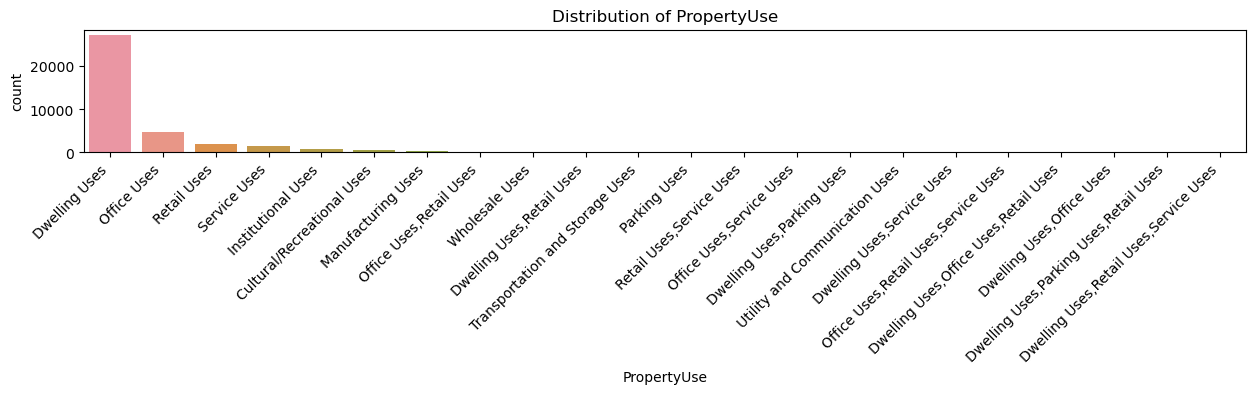

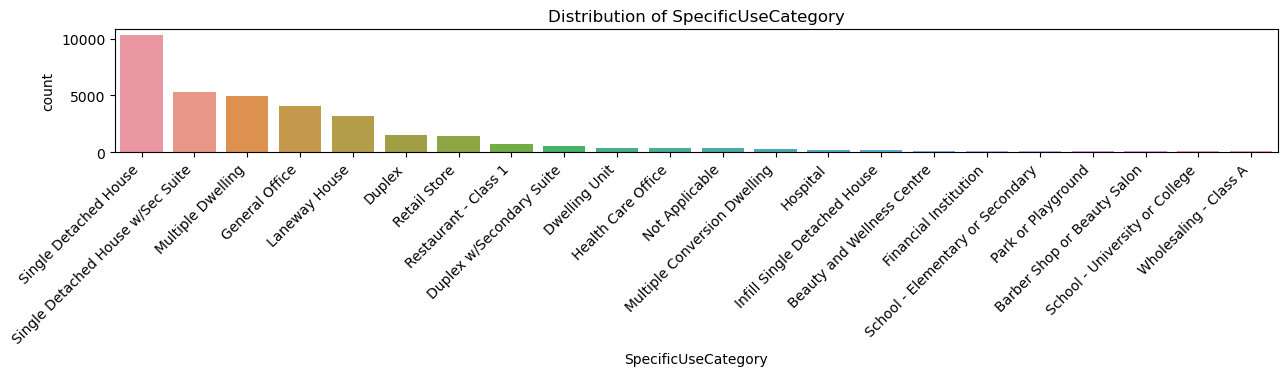

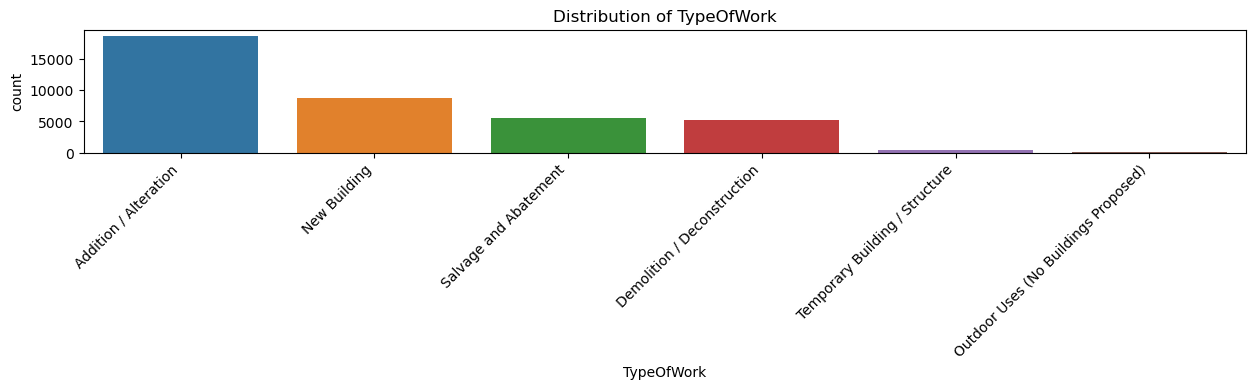

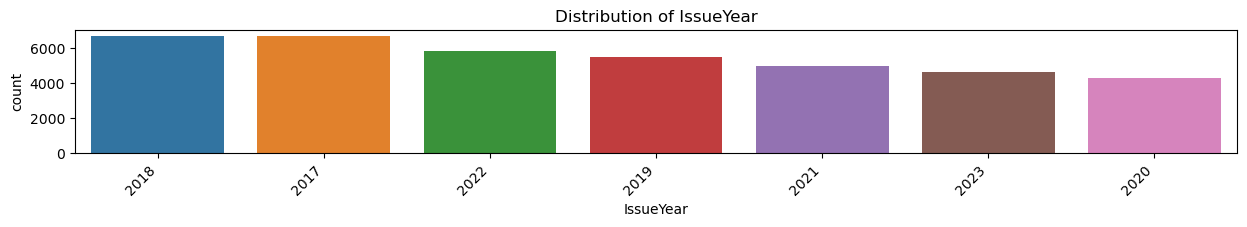

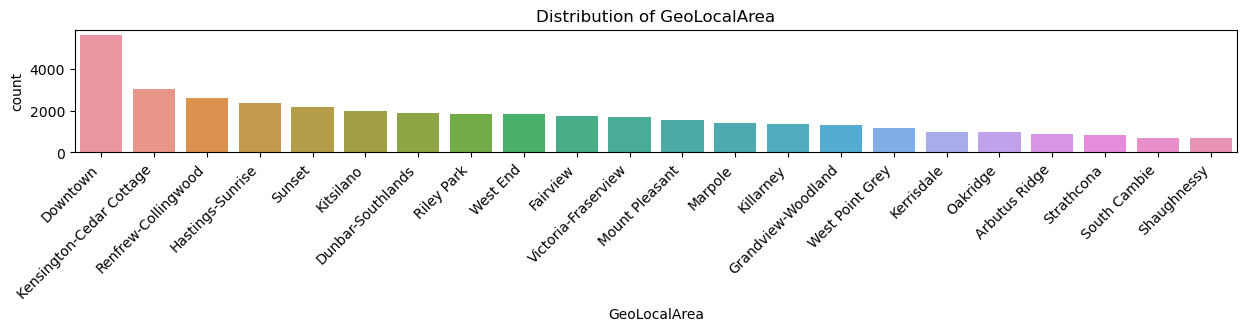

In [381]:
for i, column in enumerate(categorical_columns, 1):
    plt.figure(figsize=(15, 15))
    plt.subplot(8, 1, i)
    sns.countplot(x=column, data=df, order=df[column].value_counts().head(22).index)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45, ha='right')
    plt.show()



In [382]:
for i, column in enumerate(categorical_columns, 1):
    print(df[column].value_counts().head(40))
    print("----------")

PropertyUse
Dwelling Uses                                          27148
Office Uses                                             4800
Retail Uses                                             1874
Service Uses                                            1528
Institutional Uses                                       767
Cultural/Recreational Uses                               598
Manufacturing Uses                                       289
Office Uses,Retail Uses                                  148
Wholesale Uses                                           141
Dwelling Uses,Retail Uses                                125
Transportation and Storage Uses                          119
Parking Uses                                             107
Retail Uses,Service Uses                                  88
Office Uses,Service Uses                                  78
Dwelling Uses,Parking Uses                                71
Utility and Communication Uses                            61
Dwelling Use

### Distribution of numerical columns

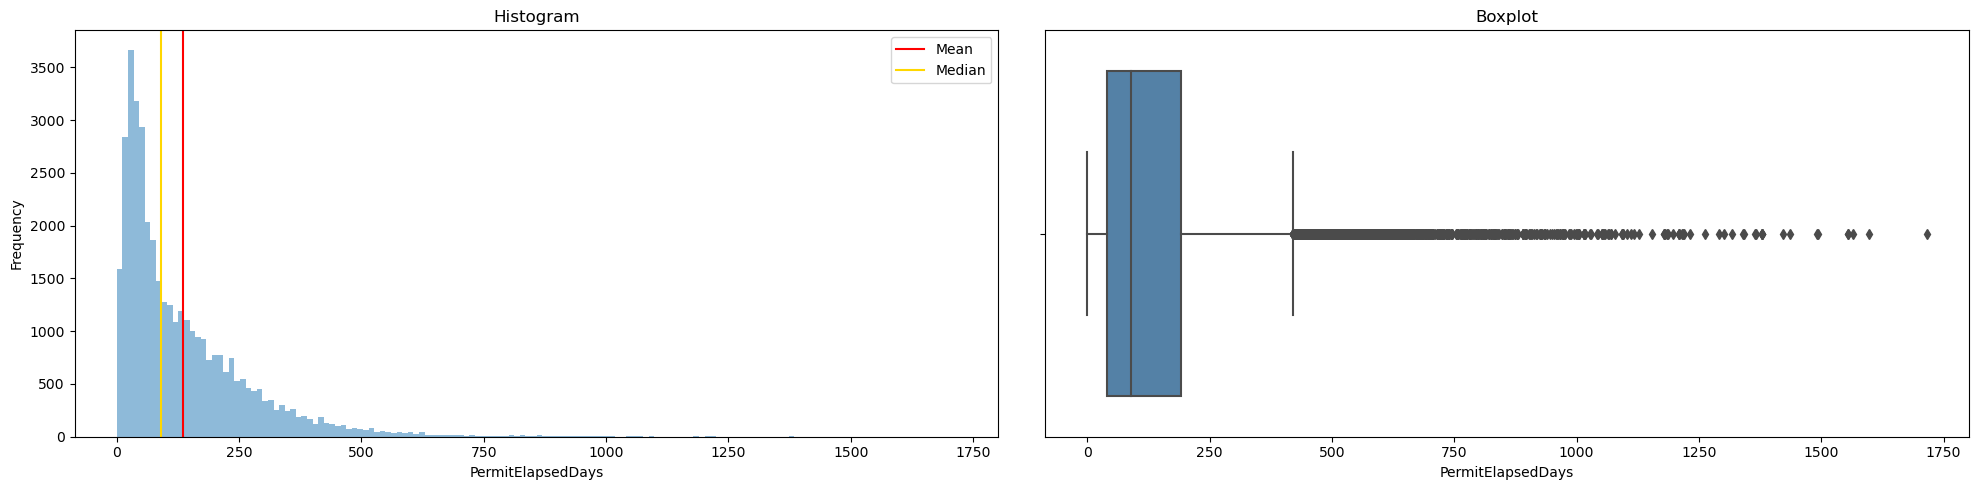

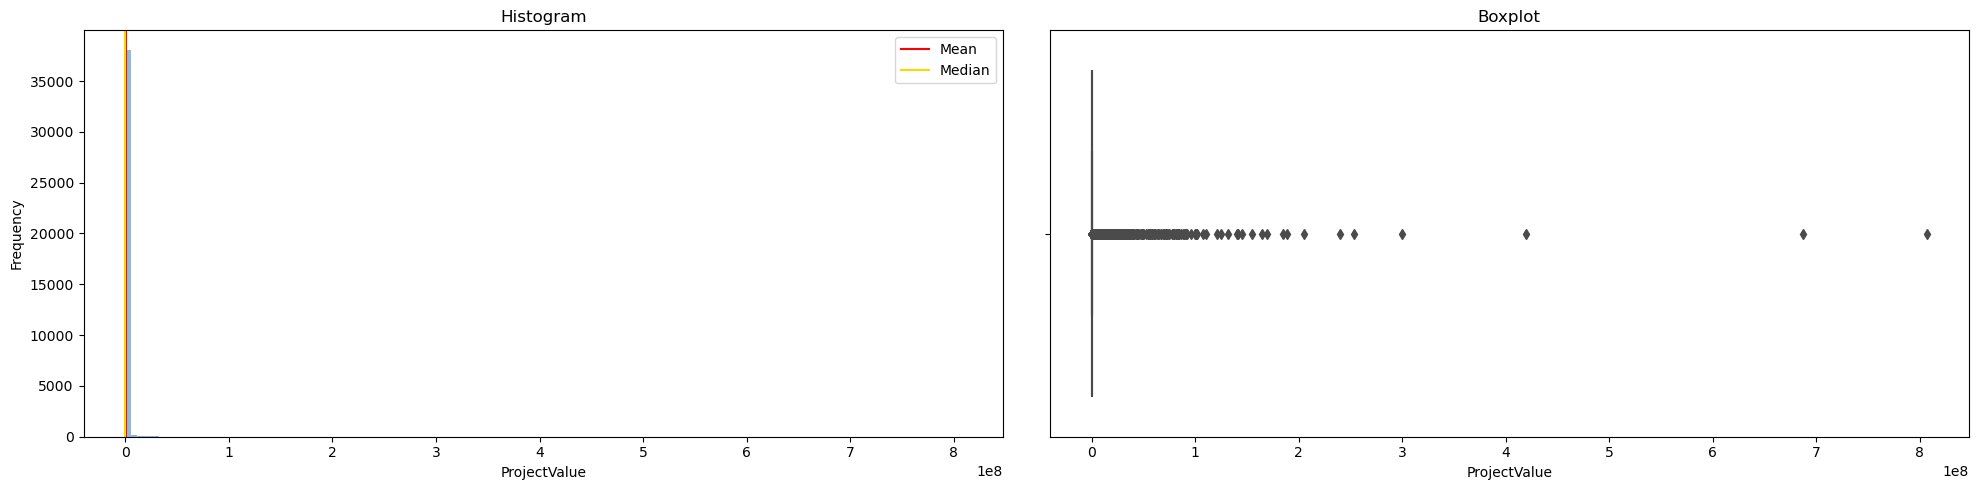

In [383]:
for col in numerical_columns:
    plt.subplots(1, 2, figsize=(20, 5))

    
    # Plot out the histogram
    plt.subplot(1, 2, 1)
    plt.hist(df[col], bins=150, alpha=0.5)
    plt.title('Histogram')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.axvline(df[col].mean(), c='red', label='Mean')
    plt.axvline(df[col].median(), c='gold', label='Median')
    plt.legend() 
    plt.tight_layout()

    # Plot the boxplot. We can use the seaborn boxplot code for this.
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color="steelblue")
    plt.title('Boxplot')


    plt.show()

In [384]:
for i, column in enumerate(numerical_columns, 1):
    print(df[column].describe())
    print("----------")

count    38608.000000
mean       136.249378
std        138.588963
min          0.000000
25%         40.000000
50%         90.000000
75%        192.000000
max       1716.000000
Name: PermitElapsedDays, dtype: float64
----------
count    3.860800e+04
mean     6.577189e+05
std      7.772650e+06
min      0.000000e+00
25%      1.050000e+04
50%      4.696000e+04
75%      2.250000e+05
max      8.071855e+08
Name: ProjectValue, dtype: float64
----------


**Insights:**
1) Predominantly, permits are issued for Dwelling Uses (single detached house, duplex) and Office Uses (General office). The number of permits for Dwelling Uses is approximately five times higher than that for Office Uses.

2) Addition/Alteration is the most common permit type, outnumbering New Building permits by a factor of five.

3) The year 2020 witnessed the lowest number of issued permits, possibly attributed to the impact of COVID-19 lockdown measures.

4) The Downtown area stands out with the highest number of issued permits, indicating increased construction or renovation activity.

5) On average, the waiting time for permit issuance is 136 days. However, the presence of numerous outliers suggests significant variations in processing times.


## Multivariate Visualizations

Let's explore the connection between property value and the waiting time for a permit.

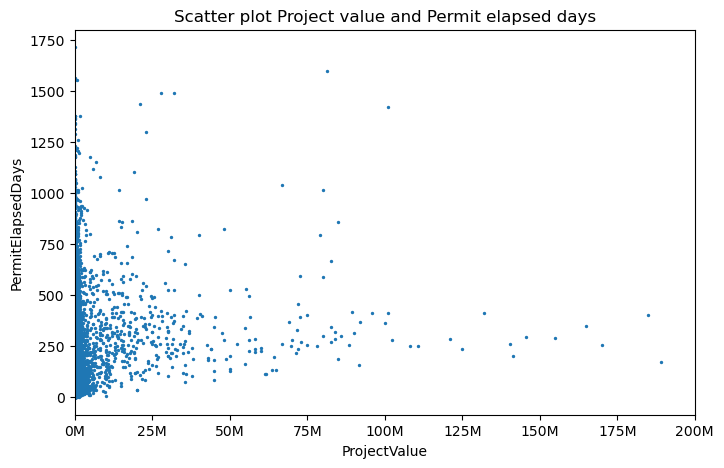

In [403]:
from matplotlib.ticker import FuncFormatter

def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'

plt.figure(figsize=(8, 5))

# using the size parameter to help readability
plt.scatter(df['ProjectValue'], df['PermitElapsedDays'], s=2, )
plt.xlabel('ProjectValue')
plt.ylabel('PermitElapsedDays')
plt.title('Scatter plot Project value and Permit elapsed days')
plt.xlim(0, 200000000)
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.show()

What about relationship between the yaer it was issued and the waiting time for a permit.

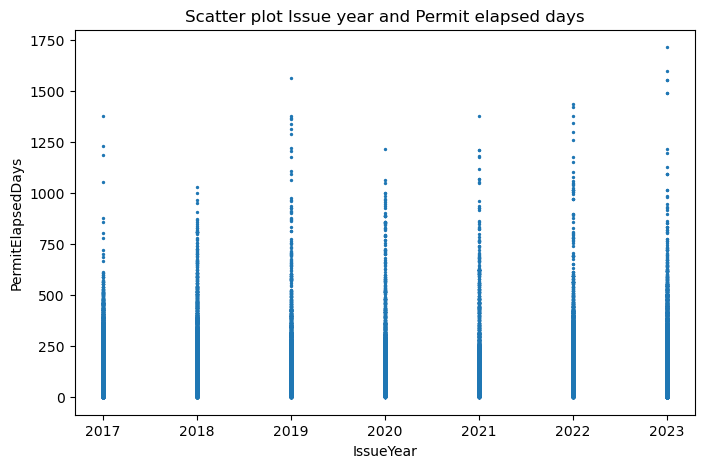

In [386]:
plt.figure(figsize=(8, 5))

# using the size parameter to help readability
plt.scatter(df['IssueYear'], df['PermitElapsedDays'], s=2, )
plt.xlabel('IssueYear')
plt.ylabel('PermitElapsedDays')
plt.title('Scatter plot Issue year and Permit elapsed days')
plt.show()

For now let's take a look into how waiting time(dayes) for a permit varies with type of work.

In [387]:

df.groupby(["TypeOfWork"])["PermitElapsedDays"].describe().sort_values(by='count',ascending=False)

,count,mean,std,min,25%,50%,75%,max
TypeOfWork,,,,,,,,
Addition / Alteration,18756.0,81.363937,109.746263,0.0,28.00,48.0,90.0,1716.0
New Building,8688.0,247.519337,142.771748,0.0,153.00,219.0,307.0,1597.0
Salvage and Abatement,5537.0,79.125158,73.498157,0.0,38.00,62.0,97.0,896.0
Demolition / Deconstruction,5220.0,216.791762,128.031030,0.0,132.00,189.5,271.0,1555.0
Temporary Building / Structure,355.0,24.135211,41.752686,0.0,2.00,7.0,20.5,389.0
Outdoor Uses (No Buildings Proposed),52.0,105.173077,196.791392,0.0,29.75,60.5,90.5,1093.0


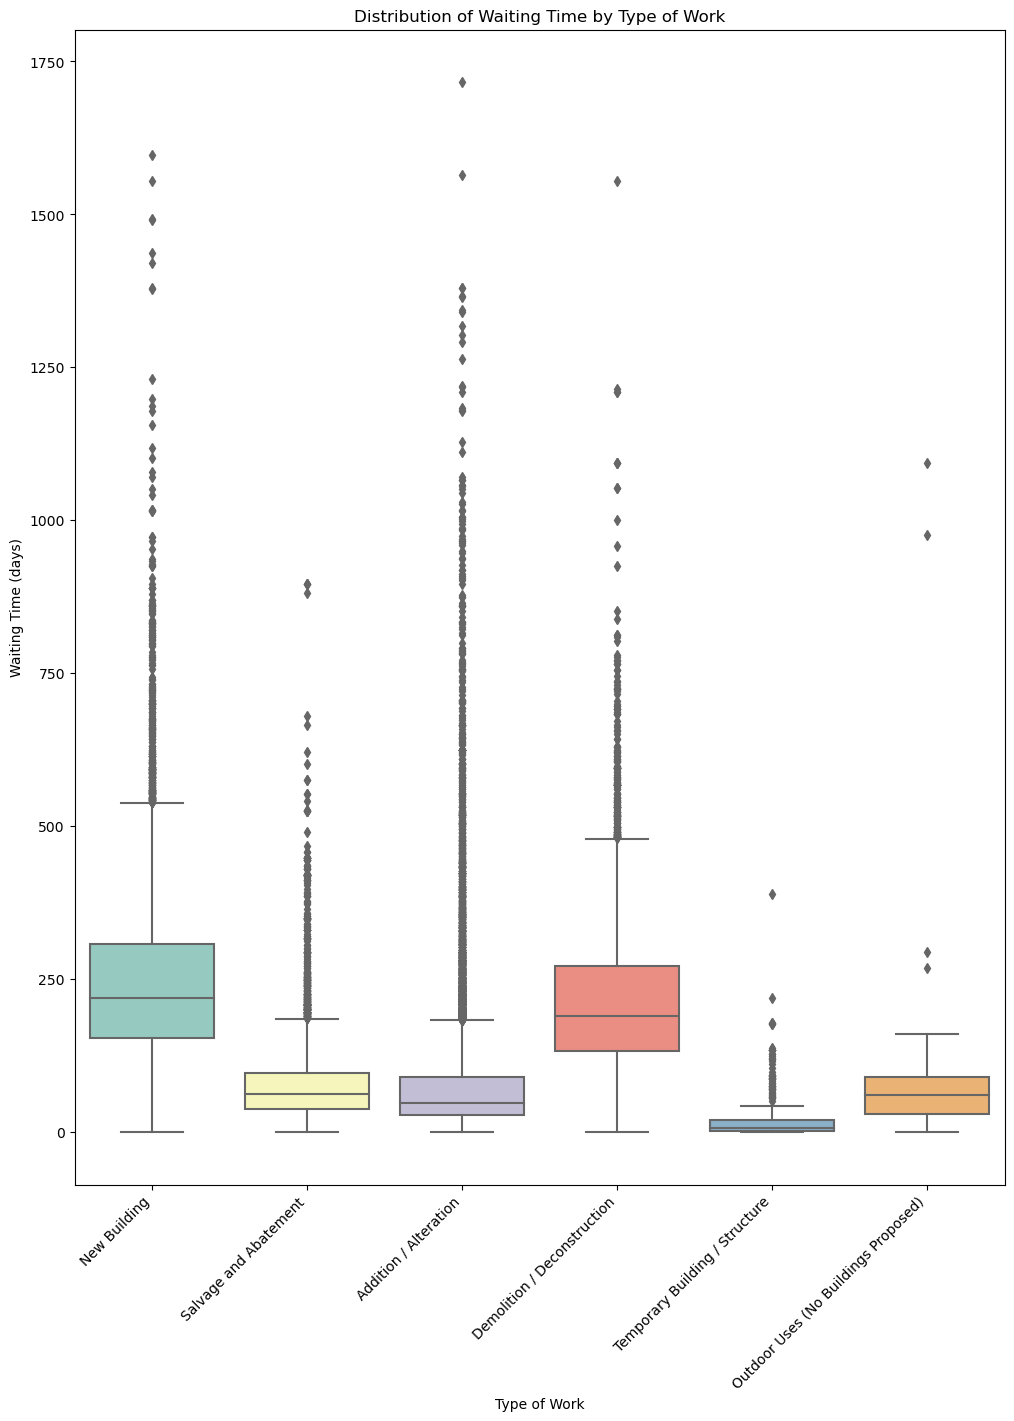

In [388]:
# Create a boxplot
plt.figure(figsize=(12, 15))
sns.boxplot(x="TypeOfWork", y="PermitElapsedDays", data=df, palette="Set3")
plt.title("Distribution of Waiting Time by Type of Work")
plt.xlabel("Type of Work")
plt.ylabel("Waiting Time (days)")
plt.xticks(rotation=45, ha="right")
plt.show()

In [389]:
from scipy.stats import ttest_ind

# Choose two property use categories for comparison
category_A = "New Building"
category_B = "Addition / Alteration"

# Extract the permit elapsed days for the chosen categories
group_A = df[df["TypeOfWork"] == category_A]["PermitElapsedDays"]
group_B = df[df["TypeOfWork"] == category_B]["PermitElapsedDays"]

# Perform the t-test
statistic, p_value = ttest_ind(group_A, group_B, equal_var=False)

# Display the results
print(f"T-statistic: {statistic}")
print(f"P-value: {p_value}")

# Check the significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between New Building and Addition / Alteration.")
else:
    print("Fail to reject the null hypothesis: No significant difference.")


T-statistic: 96.11663213603144
P-value: 0.0
Reject the null hypothesis: There is a significant difference between New Building and Addition / Alteration.


In [390]:
df.groupby(["PropertyUse"])["PermitElapsedDays"].describe().sort_values(by='count',ascending=False).head(22)


,count,mean,std,min,25%,50%,75%,max
PropertyUse,,,,,,,,
Dwelling Uses,27148.0,158.675335,139.301436,0.0,54.00,126.0,223.00,1716.0
Office Uses,4800.0,52.593958,69.728323,0.0,22.00,36.0,57.00,1317.0
Retail Uses,1874.0,75.943970,88.299347,0.0,32.00,51.0,87.00,1367.0
Service Uses,1528.0,96.678665,120.627032,0.0,35.00,62.0,112.25,1564.0
Institutional Uses,767.0,98.627119,125.631789,0.0,33.00,59.0,112.00,1180.0
Cultural/Recreational Uses,598.0,70.769231,121.528582,0.0,7.00,34.0,77.00,1184.0
Manufacturing Uses,289.0,112.799308,125.516991,0.0,37.00,70.0,138.00,1005.0
"Office Uses,Retail Uses",148.0,99.648649,124.974874,1.0,35.75,56.0,94.25,906.0
Wholesale Uses,141.0,83.971631,90.497746,7.0,33.00,56.0,100.00,697.0


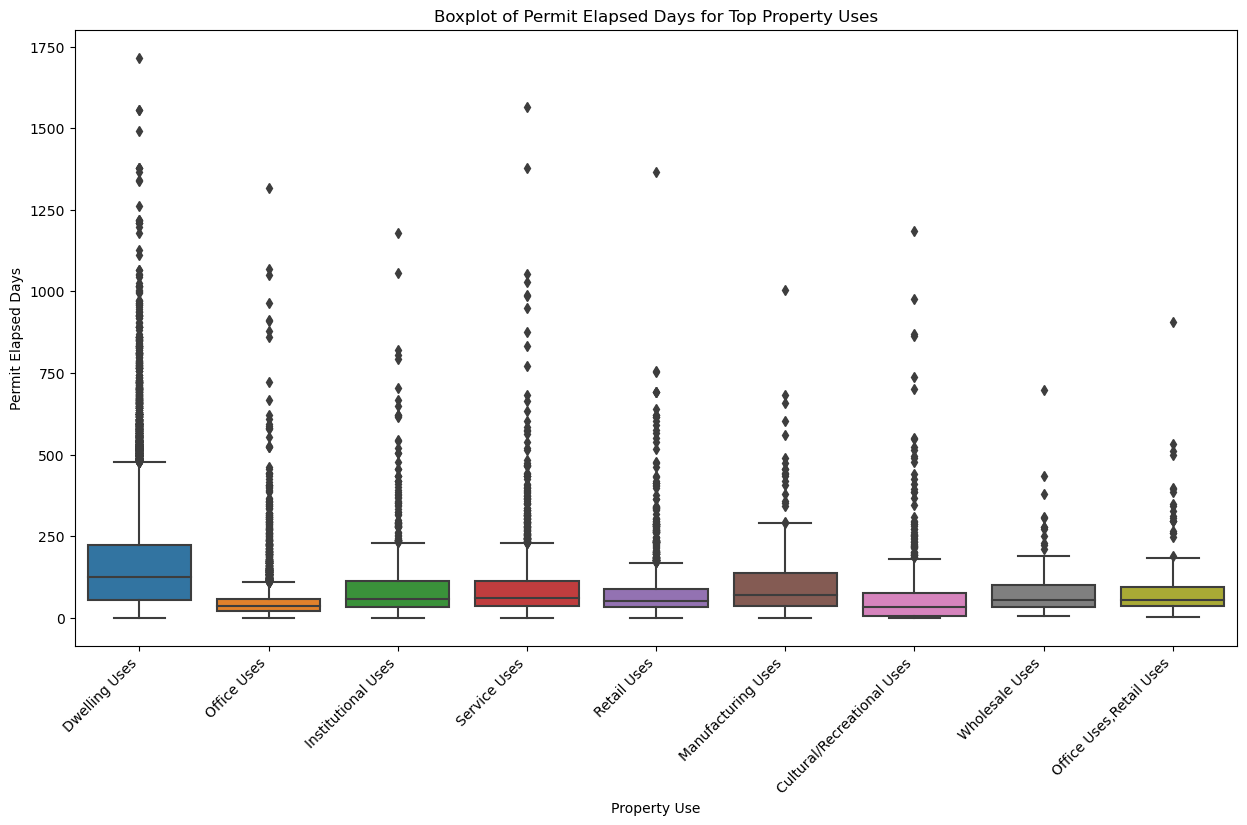

In [391]:
# Create a DataFrame with the top property uses
top_property_use = df.groupby(["PropertyUse"])["PermitElapsedDays"].describe().sort_values(by='count', ascending=False).head(9)

# Create a boxplot
plt.figure(figsize=(15, 8))
sns.boxplot(x='PropertyUse', y='PermitElapsedDays', data=df[df['PropertyUse'].isin(top_property_use.index)])
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of Permit Elapsed Days for Top Property Uses')
plt.xlabel('Property Use')
plt.ylabel('Permit Elapsed Days')
plt.show()

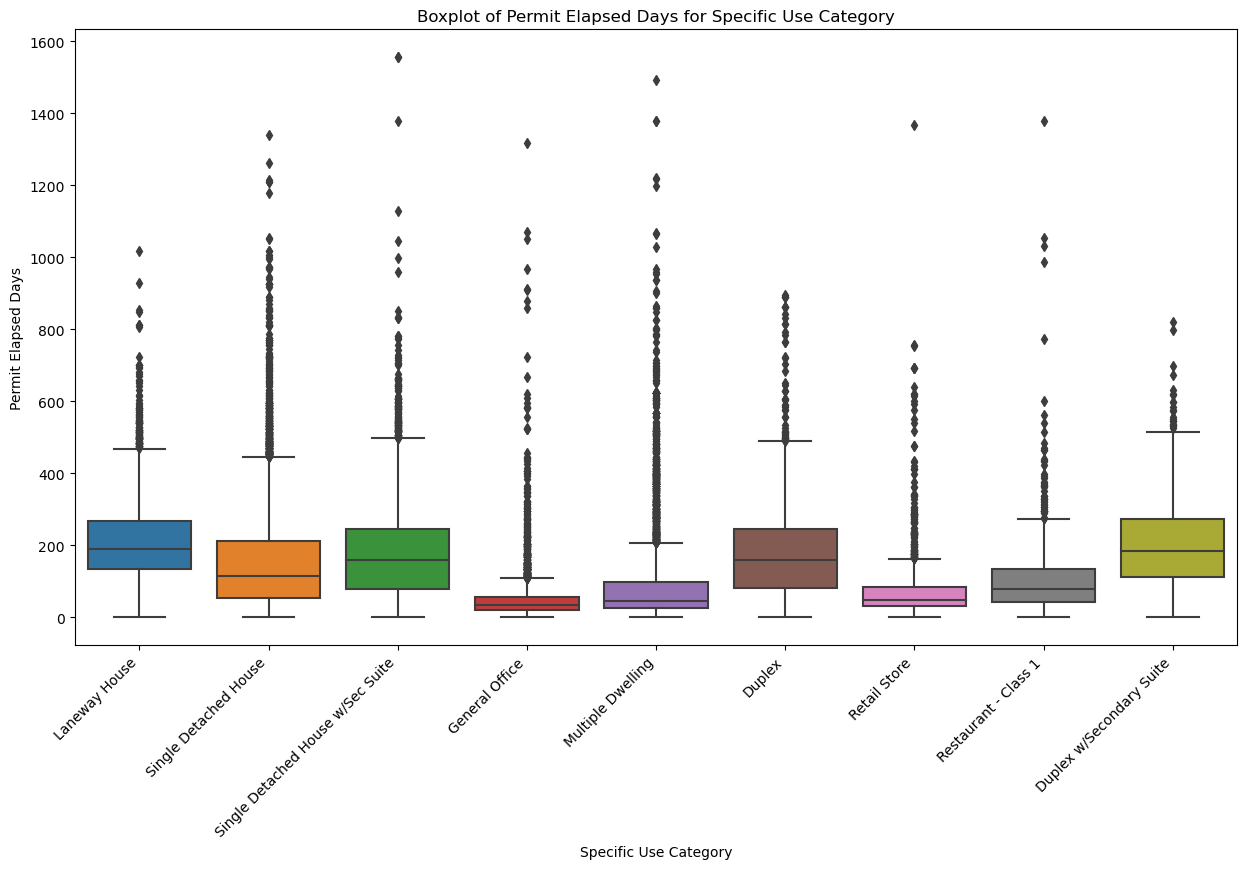

In [392]:
# Create a DataFrame with the top property uses
top_specific_use = df.groupby(["SpecificUseCategory"])["PermitElapsedDays"].describe().sort_values(by='count', ascending=False).head(9)

# Create a boxplot
plt.figure(figsize=(15, 8))
sns.boxplot(x='SpecificUseCategory', y='PermitElapsedDays', data=df[df['SpecificUseCategory'].isin(top_specific_use.index)])
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of Permit Elapsed Days for Specific Use Category')
plt.xlabel('Specific Use Category')
plt.ylabel('Permit Elapsed Days')
plt.show()

In [393]:
from scipy.stats import ttest_ind

# Choose two property use categories for comparison
category_A = "Dwelling Uses"
category_B = "Office Uses"

# Extract the permit elapsed days for the chosen categories
group_A = df[df["PropertyUse"] == category_A]["PermitElapsedDays"]
group_B = df[df["PropertyUse"] == category_B]["PermitElapsedDays"]

# Perform the t-test
statistic, p_value = ttest_ind(group_A, group_B, equal_var=False)

# Display the results
print(f"T-statistic: {statistic}")
print(f"P-value: {p_value}")

# Check the significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between Dwelling Uses and Office Uses.")
else:
    print("Fail to reject the null hypothesis: No significant difference.")


T-statistic: 80.7056945878716
P-value: 0.0
Reject the null hypothesis: There is a significant difference between Dwelling Uses and Office Uses.


**Insights:**
1) There is a positive correlation between higher property values and longer waiting times for permits, which is reasonable as more expensive projects often require more thorough analysis.
2) The average waiting time for a new building permit is 248 days, while for Addition/Alteration, it is 81 days. This disparity is expected, considering that new building projects typically involve more complexities.
3) Dwelling Uses exhibit an average waiting time of 159 days, significantly higher than other property uses such as Office Uses, which averages 52 days. This discrepancy may be attributed to a higher volume of Dwelling Uses applications, potentially leading to a shortage of staff resources. Also, the municipal department may prioritize certain types of permits over others based on various criteria. If Dwelling Uses are considered lower priority or face delays in processing, it could lead to longer waiting times.

## Time Series

### Seasonality

Let's explore **seasonality** across multiple years for **created date.**

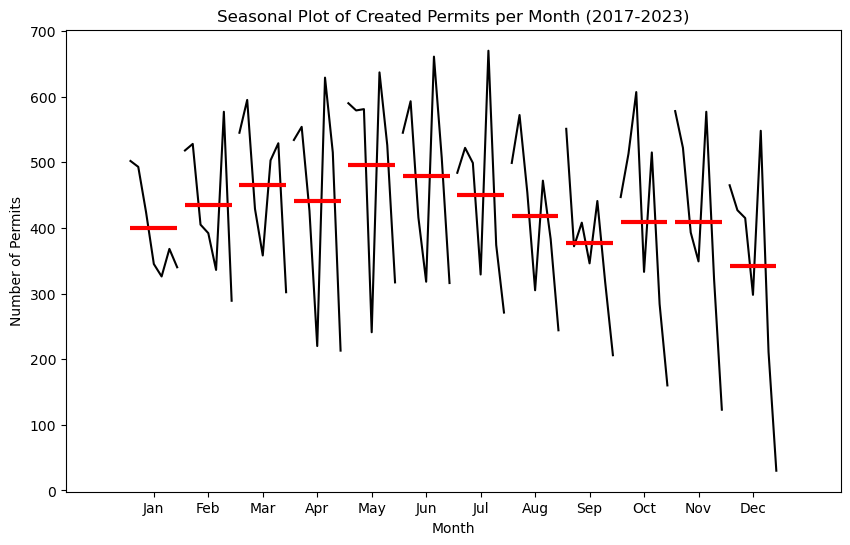

In [394]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot

# Assuming df is your DataFrame with 'PermitNumberCreatedDate' as a datetime index
df['PermitNumberCreatedDate'] = pd.to_datetime(df['PermitNumberCreatedDate'])
df_season = df.copy()
df_season = df_season[df_season["PermitNumberCreatedDate"].dt.year != 2013]
df_season = df_season[df_season["PermitNumberCreatedDate"].dt.year != 2014]
df_season = df_season[df_season["PermitNumberCreatedDate"].dt.year != 2015]
df_season = df_season[df_season["PermitNumberCreatedDate"].dt.year != 2016]

df_season.set_index('PermitNumberCreatedDate', inplace=True)

# Resample data to get the count of permits per month
monthly_counts = df_season.resample('M').size()

# Create a seasonal plot
fig, ax = plt.subplots(figsize=(10, 6))
month_plot(monthly_counts, ax=ax)

plt.title('Seasonal Plot of Created Permits per Month (2017-2023)')
plt.xlabel('Month')
plt.ylabel('Number of Permits')
plt.show()


**Insights:**

The red bars show the average for the given month across all years, while each black line represent an individual month and the progression of values across the years. 

I observe a consistent upward trend in monthly permit applications, with May and June consistently exhibiting the highest numbers on average. The sharp decline in the middle can be attributed to the impact of the Covid lockdown. Surprisingly, the year 2023 shows an even lower number of applications compared to the Covid period.

Let's explore **seasonality** across multiple years for **issued date.**

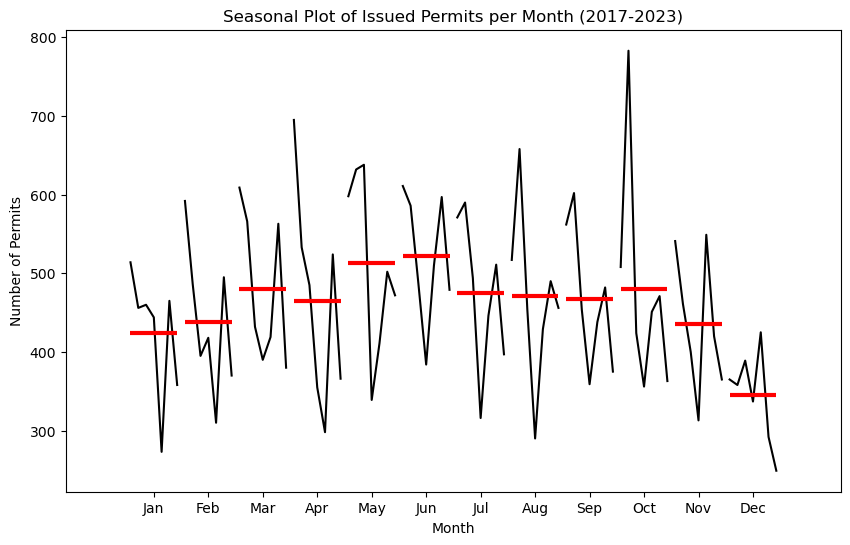

In [395]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot

# Assuming df is your DataFrame with 'IssueDate' as a datetime index
df['IssueDate'] = pd.to_datetime(df['IssueDate'])
df_season = df.copy()
df_season.set_index('IssueDate', inplace=True)

# Resample data to get the count of permits per month
monthly_counts1 = df_season.resample('M').size()

# Create a seasonal plot
fig, ax = plt.subplots(figsize=(10, 6))
month_plot(monthly_counts1, ax=ax)

plt.title('Seasonal Plot of Issued Permits per Month (2017-2023)')
plt.xlabel('Month')
plt.ylabel('Number of Permits')
plt.show()


**Insights:**

I observe a consistent upward trend in monthly issued permits, with May and June consistently exhibiting the highest numbers on average. The sharp decline in the middle can be attributed to the impact of the Covid lockdown. The year 2023 shows an  lower number of issued permits, due the lower number of applications.


### Trend-Seasonal Decomposition for PermitNumberCreatedDate

In [396]:
# decompose the time series
from statsmodels.api import tsa # time series analysis
decomposition = tsa.seasonal_decompose(monthly_counts, model='additive')

In [397]:
# add the decomposition data

monthly_counts["Trend"] = decomposition.trend
monthly_counts["Seasonal"] = decomposition.seasonal
monthly_counts["Residual"] = decomposition.resid

monthly_counts.head(50)

PermitNumberCreatedDate
2017-01-31 00:00:00    502
2017-02-28 00:00:00    518
2017-03-31 00:00:00    545
2017-04-30 00:00:00    534
2017-05-31 00:00:00    590
2017-06-30 00:00:00    545
2017-07-31 00:00:00    484
2017-08-31 00:00:00    499
2017-09-30 00:00:00    551
2017-10-31 00:00:00    447
2017-11-30 00:00:00    578
2017-12-31 00:00:00    465
2018-01-31 00:00:00    493
2018-02-28 00:00:00    528
2018-03-31 00:00:00    595
2018-04-30 00:00:00    554
2018-05-31 00:00:00    579
2018-06-30 00:00:00    593
2018-07-31 00:00:00    522
2018-08-31 00:00:00    572
2018-09-30 00:00:00    372
2018-10-31 00:00:00    513
2018-11-30 00:00:00    522
2018-12-31 00:00:00    427
2019-01-31 00:00:00    424
2019-02-28 00:00:00    405
2019-03-31 00:00:00    429
2019-04-30 00:00:00    426
2019-05-31 00:00:00    581
2019-06-30 00:00:00    416
2019-07-31 00:00:00    499
2019-08-31 00:00:00    454
2019-09-30 00:00:00    408
2019-10-31 00:00:00    607
2019-11-30 00:00:00    393
2019-12-31 00:00:00    415
2020

In [398]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=monthly_counts.index, y=monthly_counts[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=800, width=1200, showlegend=False)
fig.show()

In [399]:
df.head()

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,ProjectDescription,Applicant,PropertyUse,SpecificUseCategory,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
0,DB-2023-00041,2023-01-05,2023-04-28,113,198847.5,New Building,Low Density Housing - New Building - To constr...,Shalindro Dosanjh,Dwelling Uses,Laneway House,2023,Victoria-Fraserview,"{""coordinates"": [-123.0755831, 49.2165995], ""t...",2023-04,"49.2165995, -123.0755831"
1,BP-2023-00049,2023-01-06,2023-03-29,82,0.0,Salvage and Abatement,Low Density Housing - Salvage and Abatement - ...,John Keen DBA: Farpoint Architectural Inc.,Dwelling Uses,Single Detached House,2023,Kensington-Cedar Cottage,"{""coordinates"": [-123.081827, 49.244843], ""typ...",2023-03,"49.244843, -123.081827"
2,DB-2023-00050,2023-01-06,2023-09-12,249,1068777.5,New Building,Low Density Housing - New Building - To constr...,Embark Homes DBA: Embark Homes LTD,Dwelling Uses,Single Detached House w/Sec Suite,2023,Oakridge,"{""coordinates"": [-123.1079161, 49.2270346], ""t...",2023-09,"49.2270346, -123.1079161"
3,DB-2023-00064,2023-01-06,2023-10-04,271,155030.0,New Building,Low Density Housing - New Building - To constr...,Wayne Ng DBA: Skymark Engineering Ltd,Dwelling Uses,Laneway House,2023,Sunset,"{""coordinates"": [-123.1041746, 49.2170343], ""t...",2023-10,"49.2170343, -123.1041746"
5,BP-2023-00088,2023-01-09,2023-11-07,302,303592.0,Addition / Alteration,Field Review - Addition / Alteration - Structu...,Ian Duff DBA: Polycrete,Office Uses,General Office,2023,Kitsilano,"{""coordinates"": [-123.1470757, 49.271989], ""ty...",2023-11,"49.271989, -123.1470757"


### Trend-Seasonal Decomposition for IssueDate

In [400]:
monthly_counts1.head(4)

IssueDate
2017-01-31    514
2017-02-28    592
2017-03-31    609
2017-04-30    695
Freq: M, dtype: int64

In [401]:
# decompose the time series
from statsmodels.api import tsa # time series analysis

decomposition = tsa.seasonal_decompose(monthly_counts1, model='additive')
# add the decomposition data

monthly_counts1["Trend"] = decomposition.trend
monthly_counts1["Seasonal"] = decomposition.seasonal
monthly_counts1["Residual"] = decomposition.resid

from plotly.subplots import make_subplots
import plotly.graph_objs as go
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=monthly_counts1.index, y=monthly_counts1[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=800, width=1200, showlegend=False)
fig.show()

**Insight:**

After experiencing a decline during the COVID-19 period, the number of permit applications exhibited a subsequent increase around the beginning of 2022. Surprisingly, in 2023, the application count dropped even lower than during the COVID-19 period. It's important to note that the decrease in issued permits in 2023 is directly tied to the overall low level of applications rather than any issues related to permit approval.

# Conclusion

The analysis of permit data reveals valuable insights into the dynamics of construction activities and the permit application process in the given dataset.

**General Insights:**

   **Property Usage and Permit Types:**
   
- Predominantly, permits are issued for Dwelling Uses (single detached house, duplex) and Office Uses (General office). The number of permits for Dwelling Uses is approximately five times higher than that for Office Uses.
        
- Addition/Alteration is the most common permit type, outnumbering New Building permits by a factor of five.

**Yearly Trends:**

- The year 2020 witnessed the lowest number of issued permits, possibly attributed to the impact of COVID-19 lockdown measures.

- The Downtown area stands out with the highest number of issued permits, indicating increased construction or renovation activity.

**Processing Times:**

- On average, the waiting time for permit issuance is 136 days. However, the presence of numerous outliers suggests significant variations in processing times.

**Relationships and Correlations:**

   **Property Values and Waiting Times:**

- There is a positive correlation between higher property values and longer waiting times for permits, which is reasonable as more expensive projects often require more thorough analysis.

- The average waiting time for a new building permit is 248 days, while for Addition/Alteration, it is 81 days. This disparity is expected, considering that new building projects typically involve more complexities.

- Dwelling Uses exhibit an average waiting time of 159 days, significantly higher than other property uses such as Office Uses, which averages 52 days. This discrepancy may be attributed to a higher volume of Dwelling Uses applications, potentially leading to a shortage of staff resources.

**Seasonal Trends:**

   **Monthly Permit Applications:**

- There is a consistent upward trend in monthly permit applications, with May and June consistently exhibiting the highest numbers on average.

- The sharp decline in the middle can be attributed to the impact of the Covid lockdown.

- Surprisingly, the year 2023 shows an even lower number of applications compared to the Covid period.

**Monthly Issued Permits:**

- There is a consistent upward trend in monthly issued permits, with May and June consistently exhibiting the highest numbers on average.

- The sharp decline in the middle can be attributed to the impact of the Covid lockdown.

- The year 2023 shows an even lower number of issued permits compared to the Covid period, due to the lower number of applications.

**Overall Insights:**

After experiencing a decline during the COVID-19 period, the number of permit applications exhibited a subsequent increase around the beginning of 2022. However, surprisingly, in 2023, the application count dropped even lower than during the COVID-19 period. It's important to note that the decrease in issued permits in 2023 is directly tied to the overall low level of applications rather than any issues related to permit approval.

<div id="container" style="position:relative;">
<div style="position:relative; float:right">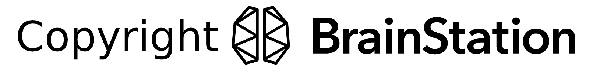
</div>
</div>
